In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out


In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm


class Generate_data():
    def __init__(self, datapath):
        """
        Generate_data class
        Two methods to be used
        1-split_test
        2-save_images
        [Note] that you have to split the public and private from fer2013 file
        """
        self.data_path = datapath

    def split_test(self, test_filename = 'finaltest', val_filename= 'val'):
        """
        Helper function to split the validation and test data from general test file as it contains (Public test, Private test)
            params:-
                data_path = path to the folder that contains the test data file
        """
        csv_path = self.data_path +"/"+ 'test.csv'
        test = pd.read_csv(csv_path)
        validation_data = pd.DataFrame(test.iloc[:3589,:])
        test_data = pd.DataFrame(test.iloc[3589:,:])
        test_data.to_csv(self.data_path+"/"+test_filename+".csv")
        validation_data.to_csv(self.data_path+"/"+val_filename+".csv")
        print("Done splitting the test file into validation & final test file")

    def str_to_image(self, str_img = ' '):
        '''
        Convert string pixels from the csv file into image object
            params:- take an image string
            return :- return PIL image object
        '''
        imgarray_str = str_img.split(' ')
        imgarray = np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48)
        return Image.fromarray(imgarray)

    def save_images(self, datatype='train'):
        '''
        save_images is a function responsible for saving images from data files e.g(train, test) in a desired folder
            params:-
            datatype= str e.g (train, val, finaltest)
        '''
        foldername= self.data_path+"/"+datatype
        csvfile_path= self.data_path+"/"+datatype+'.csv'
        if not os.path.exists(foldername):
            os.mkdir(foldername)

        data = pd.read_csv(csvfile_path)
        images = data['pixels'] #dataframe to series pandas
        numberofimages = images.shape[0]
        for index in tqdm(range(numberofimages)):
            img = self.str_to_image(images[index])
            img.save(os.path.join(foldername,'{}{}.jpg'.format(datatype,index)),'JPEG')
        print('Done saving {} data'.format((foldername)))


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Plain_Dataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        '''
        Pytorch Dataset class
        params:-
                 csv_file : the path of the csv file    (train, validation, test)
                 img_dir  : the directory of the images (train, validation, test)
                 datatype : string for searching along the image_dir (train, val, test)
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
        self.csv_file = pd.read_csv(csv_file)
        self.lables = self.csv_file['emotion']
        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.img_dir+self.datatype+str(idx)+'.jpg')
        lables = np.array(self.lables[idx])
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        return img,lables

#Helper function
def eval_data_dataloader(csv_file,img_dir,datatype,sample_number,transform= None):
    '''
    Helper function used to evaluate the Dataset class
    params:-
            csv_file : the path of the csv file    (train, validation, test)
            img_dir  : the directory of the images (train, validation, test)
            datatype : string for searching along the image_dir (train, val, test)
            sample_number : any number from the data to be shown
    '''
    if transform is None :
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    dataset = Plain_Dataset(csv_file=csv_file,img_dir = img_dir,datatype = datatype,transform = transform)

    label = dataset.__getitem__(sample_number)[1]
    print(label)
    imgg = dataset.__getitem__(sample_number)[0]
    imgnumpy = imgg.numpy()
    imgt = imgnumpy.squeeze()
    plt.imshow(imgt)
    plt.show()


In [3]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

from data_loaders import Plain_Dataset, eval_data_dataloader
from deep_emotion import Deep_Emotion
from generate_data import Generate_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(validation_dataset)
        val_acc = val_correct.double() / len(validation_dataset)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")


generate_dataset = Generate_data("data//")
generate_dataset.split_test()
generate_dataset.save_images()
generate_dataset.save_images('finaltest')
generate_dataset.save_images('val')

epochs = 100
lr = 0.005
batchsize = 128


net = Deep_Emotion()
net.to(device)
print("Model archticture: ", net)
traincsv_file = 'data'+'/'+'train.csv'  #remove
validationcsv_file = 'data'+'/'+'val.csv'
train_img_dir = 'data'+'/'+'train/'
validation_img_dir = 'data'+'/'+ 'val/'

transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset= Plain_Dataset(csv_file=traincsv_file, img_dir = train_img_dir, datatype = 'train', transform = transformation)
validation_dataset= Plain_Dataset(csv_file=validationcsv_file, img_dir = validation_img_dir, datatype = 'val', transform = transformation)
train_loader= DataLoader(train_dataset,batch_size=batchsize,shuffle = True,num_workers=0)
val_loader=   DataLoader(validation_dataset,batch_size=batchsize,shuffle = True,num_workers=0)

criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(net.parameters(),lr= lr)
Train(epochs, train_loader, val_loader, criterion, optmizer, device)


Done splitting the test file into validation & final test file


100%|███████████████████████████████████████████████████████████████████████████| 28709/28709 [01:13<00:00, 392.79it/s]


Done saving data///train data


100%|█████████████████████████████████████████████████████████████████████████████| 3589/3589 [00:08<00:00, 426.53it/s]


Done saving data///finaltest data


100%|█████████████████████████████████████████████████████████████████████████████| 3589/3589 [00:08<00:00, 428.58it/s]


Done saving data///val data
Model archticture:  Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, d

KeyError: 'emotion'

Face not detected


NameError: name 'face_roi' is not defined

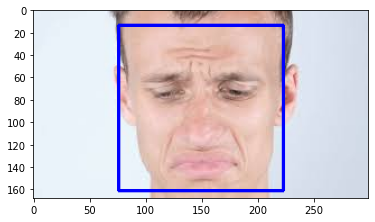

In [15]:
torch.save(net.state_dict(), 'new_Emotion_trained_Lea.pt')     

net = Deep_Emotion()
net.load_state_dict(torch.load('new_Emotion_trained_Lea.pt'))
net.to(device)

# Test it on a saved image:

import matplotlib.pyplot as plt

get_ipython().system('pip install opencv-python')

import cv2

frame = cv2.imread("C:\\Users\\User\\Downloads\\Deep-Emotion-master\\download.jpg")

get_ipython().system('pip install deepface')

from deepface import DeepFace

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
for x,y,w,h in faces:
    roi_gray = gray [y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex: ex+ew]
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.imshow(face_roi)
gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
final_image = cv2.resize(gray, (48,48))
final_image = np.expand_dims(final_image, axis = 0)
final_image = np.expand_dims(final_image, axis = 0)
final_image = final_image/255.0
dataa = torch.from_numpy(final_image)
dataa = dataa.type(torch.FloatTensor)
dataa = dataa.to(device)
outputs = net(dataa)
pred = F.softmax(outputs, dim = 1)
print(torch.argmax(pred))
index_pred = torch.argmax(pred)
#if (index_pred == 5):
print('Just checking the values')

import cv2
#pip install opencv-python
#pip install opencv-contriv-python
get_ipython().system('pip install deepface')
from deepface import DeepFace


# Live Demo
path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

# set rectangle background to white
rectangle_bgr = (255,255,255)
#make a black image
img = np.zeros((500,500))
#set some text
text = "Some text in a box!"
#get the width and height of the text box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
#set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25
#make the coords of the box with a small padding of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale = font_scale, color = (0,0,0), thickness = 1)

cap = cv2.VideoCapture(1)
#check if the webcam is opened correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcame")
    
while True:
    ret,frame = cap.read()
    #eye_cascade
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face not detected")
        else:
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey:ey+eh, ex:ex+ew]
    
    graytemp = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
    final_image = cv2.resize(graytemp, (48,48))
    final_image = np.expand_dims(final_image, axis = 0)
    final_image = np.expand_dims(final_image, axis = 0)
    final_image = final_image/255.0
    dataa = torch.from_numpy(final_image)
    dataa = dataa.type(torch.FloatTensor)
    dataa = dataa.to(device)
    outputs = net(dataa)
    Pred = F.softmax(outputs, dim = 1)
    Predictions = torch.argmax(Pred)
    print(Predictions)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    if ((Predictions)==0):
        status = "Angry"
        x1,y1,w1,h1 = 0,0,175,75
        #black background
        cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
        #text
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0, 255), 2)
        cv2.putText(frame, status, (100,150), font, 3 , (0,0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,0,255))
        
    elif ((Predictions)==1):
        status = "Disgust"
        x1,y1,w1,h1 = 0,0,175,75
        #black background
        cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
        #text
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0, 255), 2)
        cv2.putText(frame, status, (100,150), font, 3 , (0,0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,0,255))
        
    elif ((Predictions)==2):
        status = "Fear"
        x1,y1,w1,h1 = 0,0,175,75
        #black background
        cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
        #text
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0, 255), 2)
        cv2.putText(frame, status, (100,150), font, 3 , (0,0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,0,255))
        
    elif ((Predictions)==3):
        status = "Happy"
        x1,y1,w1,h1 = 0,0,175,75
        #black background
        cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
        #text
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0, 255), 2)
        cv2.putText(frame, status, (100,150), font, 3 , (0,0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,0,255))
        
    elif ((Predictions)==4):
        status = "Sad"
        x1,y1,w1,h1 = 0,0,175,75
        #black background
        cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
        #text
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0, 255), 2)
        cv2.putText(frame, status, (100,150), font, 3 , (0,0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,0,255))
        
    elif ((Predictions)==5):
        status = "Surprise"
        x1,y1,w1,h1 = 0,0,175,75
        #black background
        cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
        #text
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0, 255), 2)
        cv2.putText(frame, status, (100,150), font, 3 , (0,0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,0,255))
        
    elif ((Predictions)==6):
        status = "Neutral"
        x1,y1,w1,h1 = 0,0,175,75
        #black background
        cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
        #text
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0, 255), 2)
        cv2.putText(frame, status, (100,150), font, 3 , (0,0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,0,255))
        
        
    cv2.imshow('Face Emotion Recognition', frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

    